# UFC Fight Outcome Classification Project

## Introduction
Mixed Martial Arts (MMA) has witnessed an unprecedented surge in popularity over the years, with the Ultimate Fighting Championship (UFC) at its forefront. As MMA enthusiasts, we are often intrigued by the performance of fighters in the octagon. Understanding what distinguishes a winning fighter from the rest is a question that has intrigued both fans and analysts alike.

In this project, we embark on an exciting journey to explore and analyze data related to UFC fighters. Our primary objective is to build machine learning models that can predict the outcome of a UFC fight based on various fighter attributes and statistics. By leveraging the power of data science and machine learning, we aim to unravel the factors that contribute to a fighter's success in the UFC. 


## Data Preprocessing
### Data Collection
Collected physical stats, career stats and recent fights from fighter's page

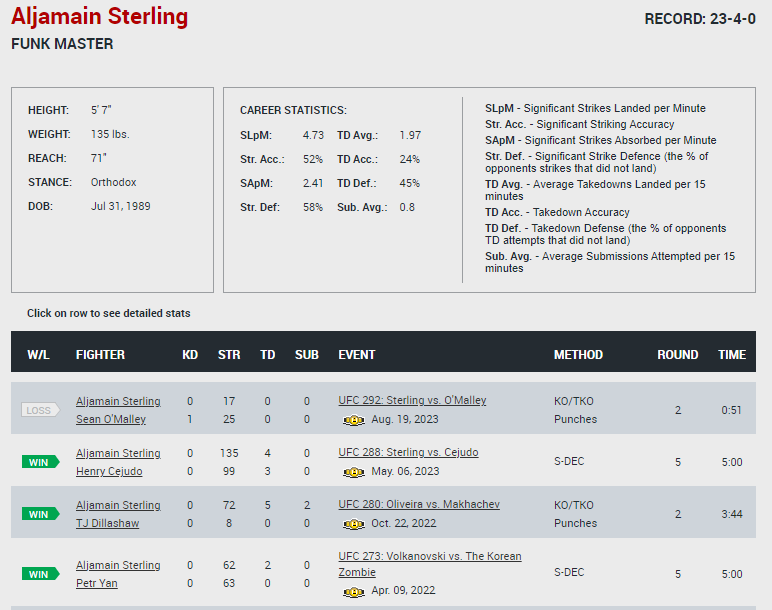

Collected fight stats from a fight page

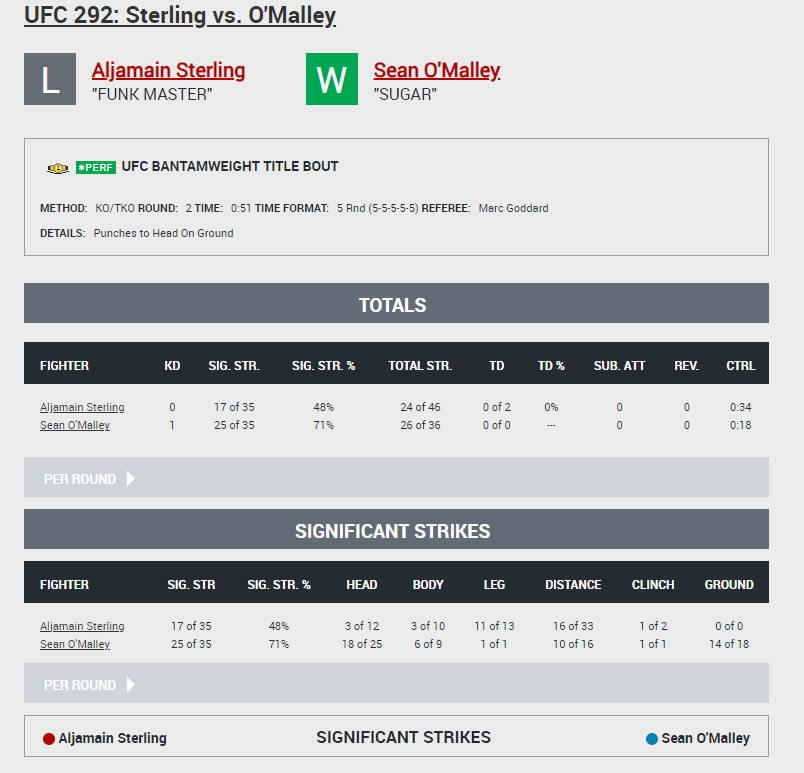


### Data Manipulation

Lots of data cleaning, converting values from string to numeric.

Converting data to a more manipulable format e.g. Ctrl time : 1:30 to 90 seconds.

Splitting values: EX: SIG STR : 17 of 35 -> SIG STR LANDED 17 , SIG STR ATTEMPTED 35

Some features were added with feature engineering. Things I thought could be relevant. EX. Streak


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from bs4 import BeautifulSoup
import requests
import re
from datetime import datetime


In [2]:
# CREATING FUNCTION to get each fight urls from a fighter's URL
def get_fighter_fight_urls(fighter_url):
    page = requests.get(fighter_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    fight_urls = []
    
    fight_rows = soup.find_all('tr', class_='b-fight-details__table-row')
    for fight_row in fight_rows:
        onclick_value = fight_row.get('onclick')
        if onclick_value:
            match = re.search(r"'(http://www.ufcstats.com/fight-details/.+?)'", onclick_value)
            if match:
                fight_link = match.group(1)
                fight_urls.append(fight_link)
    
    return fight_urls


#Scrape fighter statistics
import datetime
def get_numeric_value(value_str):
    try:
        return float(value_str)
    except ValueError:
        return None

def convert_height(height_str):
    height_str = height_str.replace('"', '')
    feet, inches = map(int, height_str.split("'"))
    total_inches = feet * 12 + inches
    return total_inches

def convert_weight(weight_str):
    return float(weight_str.replace('lbs.', '').strip())

def convert_reach(reach_str):
    if reach_str == '--':
        return None
    return float(reach_str.replace('"', '').strip())

def convert_percentage(percentage_str):
    try:
        if isinstance(percentage_str, str):
            numeric_value = float(percentage_str.replace('%', '')) / 100
            return numeric_value
        elif isinstance(percentage_str, float):
            return percentage_str  # Already a float, no conversion needed
    except ValueError:
        return None

def fighter_stats(fighter_url):
    fighter_page = requests.get(fighter_url)
    fighter_soup = BeautifulSoup(fighter_page.content, 'html.parser')

    fighter_data = {}
    fighter_physical_stats = fighter_soup.find('div', class_='b-list__info-box')
    if fighter_physical_stats:
        physical_details = fighter_physical_stats.find_all('li', class_='b-list__box-list-item')
        for detail in physical_details:
            label = detail.find('i', class_='b-list__box-item-title').get_text(strip=True)
            value = detail.get_text(strip=True).replace(label, '').strip()

            if label == 'Height:':
                fighter_data[label] = convert_height(value)
            elif label == 'Weight:':
                fighter_data[label] = convert_weight(value)
            elif label == 'Reach:':
                fighter_data[label] = convert_reach(value)
            else:
                fighter_data[label] = value

    fighter_career_stats = fighter_soup.find('div', class_='b-list__info-box-left')
    if fighter_career_stats:
        career_stats = fighter_career_stats.find_all('li', class_='b-list__box-list-item')
        for stat in career_stats:
            label_element = stat.find('i', class_='b-list__box-item-title')
            value = stat.get_text(strip=True).replace(label_element.get_text(strip=True), '').strip()
            label = label_element.get_text(strip=True).rstrip(':')

            if label in ['Str. Acc.', 'Str. Def', 'TD Acc.', 'TD Def.']:
                new_label = f"{label} (%)"
                converted_value = convert_percentage(value)
                fighter_data[new_label] = converted_value
            else:
                fighter_data[label] = value

    cols_to_strip_percent = ['Str. Acc. (%)', 'Str. Def (%)', 'TD Acc. (%)', 'TD Def. (%)']
    fighter_df = pd.DataFrame([fighter_data])
    fighter_df[cols_to_strip_percent] = fighter_df[cols_to_strip_percent].replace('%', '', regex=True)
    
    
    fighter_df['DOB:'] = pd.to_datetime(fighter_df['DOB:'], format='%b %d, %Y')
    today = datetime.datetime.today()
    fighter_df['Age'] = (today - fighter_df['DOB:']).apply(lambda x: x.days // 365)
    fighter_df.drop(columns=['DOB:'], inplace=True)

    fighter_df.drop('', axis=1, inplace=True)
    return fighter_df


def get_opponent_stats(fighter_url):
    opponent_urls = []

    fighter_page = requests.get(fighter_url)
    fighter_soup = BeautifulSoup(fighter_page.content, 'html.parser')

    recent_fights_table = fighter_soup.find('table')
    recent_fights_rows = recent_fights_table.find_all('tr')

    for row in recent_fights_rows:
        fighter_column = row.find('td', class_='b-fight-details__table-col l-page_align_left')
        
        if fighter_column:
            fighter_links = fighter_column.find_all('a', class_='b-link b-link_style_black')
            if len(fighter_links) >= 2:
                opponent_url = fighter_links[1]['href']
                opponent_urls.append(opponent_url)
    
    opponent_stats_dfs = []
    for opponent_url in opponent_urls:
        opponent_stats_df = fighter_stats(opponent_url)
        opponent_stats_dfs.append(opponent_stats_df)
    
    combined_opponent_stats = pd.concat(opponent_stats_dfs, ignore_index=True)
    combined_opponent_stats.columns = ["Opponent " + col for col in combined_opponent_stats.columns]
    return combined_opponent_stats


def scrape_fight_data(fight_url):   
    fight_page = requests.get(fight_url)
    fight_soup = BeautifulSoup(fight_page.content, 'html.parser')

    data = []
    fight_table = fight_soup.find('tbody', class_='b-fight-details__table-body')

    fighter_divs = fight_soup.find_all('div', class_='b-fight-details__person')
    outcomes = [outcome_tag.get_text(strip=True) if (outcome_tag := fighter_div.find('i', class_='b-fight-details__person-status')) else None for fighter_div in fighter_divs]

    for row in fight_table.find_all('tr', class_='b-fight-details__table-row'):
        fighter_names = row.find_all('a', class_='b-link_style_black')
        fighters = [name.get_text(strip=True) for name in fighter_names]

        kd = [col.get_text(strip=True) for col in row.find_all('td')[1].find_all('p')]
        sig_str = [col.get_text(strip=True) for col in row.find_all('td')[2].find_all('p')]
        sig_str_percent = [col.get_text(strip=True) for col in row.find_all('td')[3].find_all('p')]
        total_str = [col.get_text(strip=True) for col in row.find_all('td')[4].find_all('p')]
        td = [col.get_text(strip=True) for col in row.find_all('td')[5].find_all('p')]
        td_percent = [col.get_text(strip=True) for col in row.find_all('td')[6].find_all('p')]
        sub_att = [col.get_text(strip=True) for col in row.find_all('td')[7].find_all('p')]
        rev = [col.get_text(strip=True) for col in row.find_all('td')[8].find_all('p')]
        ctrl = [col.get_text(strip=True) for col in row.find_all('td')[9].find_all('p')]

        for i in range(len(fighters)):
            fight_info = {
                'Fighter': fighters[i],
                'KD': kd[i],
                'Sig. str.': sig_str[i],
                'Sig. str. %': sig_str_percent[i],
                'Total str.': total_str[i],
                'Td': td[i],
                'Td %': td_percent[i],
                'Sub. att': sub_att[i],
                'Rev.': rev[i],
                'Ctrl': ctrl[i],
                'Fight URL': fight_url,
                'Outcome': outcomes[i] 
            }
            data.append(fight_info)

    df = pd.DataFrame(data)

    new_data = []
    new_columns = [
        'Fighter', 'Opponent', 'KD', 'Opponent KD', 'Sig. str.', 'Opponent Sig. str.',
        'Sig. str. %', 'Opponent Sig. str. %', 'Total str.', 'Opponent Total str.',
        'Td', 'Opponent Td', 'Td %', 'Opponent Td %', 'Sub. att', 'Opponent Sub. att',
        'Rev.', 'Opponent Rev.', 'Ctrl', 'Opponent Ctrl', 'Outcome'
    ]

    for i in range(0, len(df), 2):
        fighter_row = df.iloc[i]
        opponent_row = df.iloc[i + 1]

        new_row = [
            fighter_row['Fighter'], opponent_row['Fighter'],
            fighter_row['KD'], opponent_row['KD'],
            fighter_row['Sig. str.'], opponent_row['Sig. str.'],
            fighter_row['Sig. str. %'], opponent_row['Sig. str. %'],
            fighter_row['Total str.'], opponent_row['Total str.'],
            fighter_row['Td'], opponent_row['Td'],
            fighter_row['Td %'], opponent_row['Td %'],
            fighter_row['Sub. att'], opponent_row['Sub. att'],
            fighter_row['Rev.'], opponent_row['Rev.'],
            fighter_row['Ctrl'], opponent_row['Ctrl'],
            fighter_row['Outcome']
        ]

        new_data.append(new_row)

    fight_df = pd.DataFrame(new_data, columns=new_columns)

    fight_df.replace('---', None, inplace=True)


    try:
        fight_df['Sig. str. %'] = fight_df['Sig. str. %'].apply(convert_percentage)
        fight_df['Opponent Sig. str. %'] = fight_df['Opponent Sig. str. %'].apply(convert_percentage)
        fight_df['Td %'] = fight_df['Td %'].apply(convert_percentage)
        fight_df['Opponent Td %'] = fight_df['Opponent Td %'].apply(convert_percentage)
    except AttributeError:
        pass  


    fight_df[['Sig. Landed', 'Sig. Attempted']] = fight_df['Sig. str.'].str.split(' of ', expand=True)
    fight_df['Sig. Landed'] = fight_df['Sig. Landed'].astype(int)
    fight_df['Sig. Attempted'] = fight_df['Sig. Attempted'].astype(int)

    fight_df[["Opponent Sig. Landed", "Opponent Sig. Attempted"]] = fight_df["Opponent Sig. str."].str.split(' of ', expand=True)
    fight_df["Opponent Sig. Landed"] = fight_df["Opponent Sig. Landed"].astype(int)
    fight_df["Opponent Sig. Attempted"] = fight_df["Opponent Sig. Attempted"].astype(int)

    fight_df[['Total Landed', 'Total Attempted']] = fight_df['Total str.'].str.split(' of ', expand=True)
    fight_df['Total Landed'] = fight_df['Total Landed'].astype(int)
    fight_df['Total Attempted'] = fight_df['Total Attempted'].astype(int)

    fight_df[['Opponent Total Landed', 'Opponent Total Attempted']] = fight_df['Opponent Total str.'].str.split(' of ', expand=True)
    fight_df['Opponent Total Landed'] = fight_df['Opponent Total Landed'].astype(int)
    fight_df['Opponent Total Attempted'] = fight_df['Opponent Total Attempted'].astype(int)

    fight_df[['Td Landed', 'Td Attempted']] = fight_df['Td'].str.split(' of ', expand=True)
    fight_df['Td Landed'] = fight_df['Td Landed'].astype(int)
    fight_df['Td Attempted'] = fight_df['Td Attempted'].astype(int)

    fight_df[['Opponent Td Landed', 'Opponent Td Attempted']] = fight_df['Opponent Td'].str.split(' of ', expand=True)
    fight_df['Opponent Td Landed'] = fight_df['Opponent Td Landed'].astype(int)
    fight_df['Opponent Td Attempted'] = fight_df['Opponent Td Attempted'].astype(int)

    fight_df.drop(['Sig. str.', "Opponent Sig. str.", 'Total str.', 'Opponent Total str.', 'Td', 'Opponent Td'], axis=1, inplace=True)

    return fight_df


#CREATE FUNCTION TO SCRAPE PAST FIGHT RESULST FROM A FIGHTER'S URL PAGE
def past_fights(fighter_url):
    fighter_page = requests.get(fighter_url)
    fighter_soup = BeautifulSoup(fighter_page.content, 'html.parser')

    # Get searched fighter's name
    fighter_name = fighter_soup.find('span', class_='b-content__title-highlight').get_text(strip=True)
    
    #Create DF from all previous fights from searched fighter
    fight_urls = get_fighter_fight_urls(fighter_url)
    all_fight_dfs = []
    for fight_url in fight_urls:
        fight_df = scrape_fight_data(fight_url)
        all_fight_dfs.append(fight_df)

    combined_df = pd.concat(all_fight_dfs, ignore_index=True)

    #Add the fight information to DF
    fight_table = fighter_soup.find('tbody', class_='b-fight-details__table-body')

    each_fight_details = fight_table.find_all('tr')

    for idx, fight in enumerate(each_fight_details[1:]):
        event_info_elements = fight.find_all('td', class_='b-fight-details__table-col l-page_align_left')
        round_time_elements = fight.find_all('td', class_='b-fight-details__table-col')

        event_name = event_info_elements[1].find_all('p')[0].text.strip()
        event_date = event_info_elements[1].find_all('p')[1].text.strip()

        try:
            method_of_victory = event_info_elements[2].find('p').text.strip()
        except AttributeError:
            method_of_victory = None
        
        rounds_element = round_time_elements[-2].find('p')
        if rounds_element:
            rounds = rounds_element.text.strip()
        else:
            rounds = None

        time_element = round_time_elements[-1].find('p')
        if time_element:
            time = time_element.text.strip()
        else:
            time = None
        ''' 
        rounds = round_time_elements[-2].find('p').text.strip()
        time = round_time_elements[-1].find('p').text.strip()'''

        combined_df.at[idx, 'Event Name'] = event_name
        combined_df.at[idx, 'Event Date'] = event_date
        combined_df.at[idx, 'Method of Victory'] = method_of_victory
        combined_df.at[idx, 'Rounds'] = rounds
        combined_df.at[idx, 'Time'] = time

    # Flip the data from Opponent to Fighter if the searched fighter is Opponent
    for index, row in combined_df.iterrows():
        if row['Opponent'] == fighter_name:
            combined_df.at[index, 'Fighter'] = row['Opponent']
            combined_df.at[index, 'Opponent'] = row['Fighter']

            combined_df.at[index, 'KD'] = row['Opponent KD']
            combined_df.at[index, 'Opponent KD'] = row['KD']

            combined_df.at[index, 'Sig. str. %'] = row['Opponent Sig. str. %']
            combined_df.at[index, 'Opponent Sig. str. %'] = row['Sig. str. %']

            combined_df.at[index, 'Td %'] = row['Opponent Td %']
            combined_df.at[index, 'Opponent Td %'] = row['Td %']

            combined_df.at[index, 'Sub. att'] = row['Opponent Sub. att']
            combined_df.at[index, 'Opponent Sub. att'] = row['Sub. att']

            combined_df.at[index, 'Rev.'] = row['Opponent Rev.']
            combined_df.at[index, 'Opponent Rev.'] = row['Rev.']

            combined_df.at[index, 'Ctrl'] = row['Opponent Ctrl']
            combined_df.at[index, 'Opponent Ctrl'] = row['Ctrl']

            if row['Outcome'] == 'W':
                combined_df.at[index, 'Outcome'] = 'L'
            elif row['Outcome'] == 'L':
                combined_df.at[index, 'Outcome'] = 'W'

            combined_df.at[index, 'Sig. Landed'] = row['Opponent Sig. Landed']
            combined_df.at[index, 'Opponent Sig. Landed'] = row['Sig. Landed']     

            combined_df.at[index, 'Sig. Attempted'] = row['Opponent Sig. Attempted']
            combined_df.at[index, 'Opponent Sig. Attempted'] = row['Sig. Attempted']  

            combined_df.at[index, 'Total Landed'] = row['Opponent Total Landed']
            combined_df.at[index, 'Opponent Total Landed'] = row['Total Landed']   

            combined_df.at[index, 'Total Attempted'] = row['Opponent Total Attempted']
            combined_df.at[index, 'Opponent Total Attempted'] = row['Total Attempted']     

            combined_df.at[index, 'Td Landed'] = row['Opponent Td Landed']
            combined_df.at[index, 'Opponent Td Landed'] = row['Td Landed']

            combined_df.at[index, 'Td Attempted'] = row['Opponent Td Attempted']
            combined_df.at[index, 'Opponent Td Attempted'] = row['Td Attempted']           
    
    #ADD OHTER INTERESTING DATA TO BE USED IN ANALYSIS

    #Add current streak
    current_streak = []
    streak_type = []

    win_streak = 0
    loss_streak = 0

    for index, row in combined_df.iterrows():
        outcome = row['Outcome']

        if outcome == 'W':
            win_streak += 1
            loss_streak = 0
        elif outcome == 'L':
            loss_streak += 1
            win_streak = 0
        else:
            win_streak = 0
            loss_streak = 0

        if win_streak > 0:
            current_streak.append(win_streak)
            streak_type.append('Win')
        elif loss_streak > 0:
            current_streak.append(loss_streak)
            streak_type.append('Loss')
        else:
            current_streak.append(0)
            streak_type.append('None')


    combined_df['Current Streak'] = current_streak
    combined_df['Streak Type'] = streak_type

    # Add how long between each fight for analysis
    
    combined_df['Event Date'] = pd.to_datetime(combined_df['Event Date'])

    combined_df = combined_df.sort_values(by='Event Date', ascending=True)

    combined_df['Days since last fight'] = (combined_df['Event Date'] - combined_df['Event Date'].shift(1)).dt.days

    combined_df['Days since last fight'].fillna(0, inplace=True)


    return combined_df



In [3]:
#CREATE A FUNCTION TO CREATE A DF FROM FIGHTER_URL
def full_past_fights(fighter_url):
    past_fights_df = past_fights(fighter_url)  

    opponent_stats_df = get_opponent_stats(fighter_url)

    combined_df = pd.concat([past_fights_df, opponent_stats_df], axis=1)

    return combined_df


#### Example of how full_past_fights works

In [4]:
full_past_fights('http://www.ufcstats.com/fighter-details/aa72b0f831d0bfe5')

C:\Users\Bootcamp\AppData\Local\Temp\ipykernel_13652\1603314924.py:259: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_fight_dfs, ignore_index=True)
C:\Users\Bootcamp\AppData\Local\Temp\ipykernel_13652\1603314924.py:293: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'UFC 283: Teixeira vs. Hill' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_df.at[idx, 'Event Name'] = event_name
C:\Users\Bootcamp\AppData\Local\Temp\ipykernel_13652\1603314924.py:294: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Jan. 21, 2023' has dtype inc

,Fighter,Opponent,KD,Opponent KD,Sig. str. %,Opponent Sig. str. %,Td %,Opponent Td %,Sub. att,Opponent Sub. att,...,Opponent STANCE:,Opponent SLpM,Opponent Str. Acc. (%),Opponent SApM,Opponent Str. Def (%),Opponent TD Avg.,Opponent TD Acc. (%),Opponent TD Def. (%),Opponent Sub. Avg.,Opponent Age
13,Deiveson Figueiredo,Marco Beltran,1,0,0.65,0.40,0.66,NaN,4,0,...,Orthodox,2.07,0.37,1.93,0.63,0.70,0.50,0.46,0.2,37
12,Deiveson Figueiredo,Jarred Brooks,0,0,0.39,0.57,0.25,0.63,5,0,...,Switch,2.12,0.46,1.66,0.62,4.54,0.57,0.69,0.6,30
11,Deiveson Figueiredo,Joseph Morales,1,0,0.50,0.28,1.00,0.00,1,0,...,Switch,1.58,0.37,1.72,0.60,0.53,0.50,0.23,2.6,29
10,Deiveson Figueiredo,John Moraga,2,0,0.74,0.53,0.50,0.00,1,1,...,Orthodox,2.57,0.43,2.55,0.56,0.62,0.23,0.44,1.1,39
9,Deiveson Figueiredo,Jussier Formiga,0,0,0.28,0.50,0.00,0.60,0,0,...,Orthodox,1.42,0.39,2.34,0.64,1.82,0.35,0.87,0.6,38
8,Deiveson Figueiredo,Alexandre Pantoja,1,0,0.59,0.40,0.66,0.20,0,0,...,Orthodox,4.41,0.48,3.81,0.51,1.75,0.44,0.66,1.0,33
7,Deiveson Figueiredo,Tim Elliott,0,0,0.61,0.68,0.00,0.33,1,0,...,Southpaw,3.47,0.44,2.76,0.56,3.88,0.47,0.60,0.9,36
6,Deiveson Figueiredo,Joseph Benavidez,1,0,0.51,0.48,1.00,0.00,1,0,...,Southpaw,3.52,0.34,2.67,0.61,1.41,0.30,0.62,0.6,39
5,Deiveson Figueiredo,Joseph Benavidez,2,0,0.87,0.64,NaN,NaN,4,0,...,Southpaw,3.52,0.34,2.67,0.61,1.41,0.30,0.62,0.6,39
4,Deiveson Figueiredo,Alex Perez,0,0,0.62,0.42,NaN,0.00,1,0,...,Orthodox,4.67,0.48,3.14,0.60,2.84,0.44,0.77,1.3,31


In [5]:
# Function to convert '0:00' format to seconds
def convert_ctrl_to_seconds(ctrl_time):
    if pd.isna(ctrl_time):
        return np.nan
    minutes, seconds = map(int, ctrl_time.split(':'))
    return minutes * 60 + seconds

In [6]:
def preprocessing_data(fighter_url):
    fighter_df = full_past_fights(fighter_url)

    fighter_df.drop(['Fighter', 'Opponent', 'Event Name', 'Event Date', 'Time','Method of Victory', "Opponent STANCE:", "Streak Type"], axis=1, inplace=True)

    fighter_df['Ctrl'] = fighter_df['Ctrl'].replace('--', np.nan)
    fighter_df['Opponent Ctrl'] = fighter_df['Opponent Ctrl'].replace('--', np.nan)

    try:
        fighter_df['Ctrl (in seconds)'] = fighter_df['Ctrl'].apply(convert_ctrl_to_seconds)
        fighter_df['Opponent Ctrl (in seconds)'] = fighter_df['Opponent Ctrl'].apply(convert_ctrl_to_seconds)
        fighter_df.drop(['Ctrl', 'Opponent Ctrl'], axis=1, inplace=True)
    except ValueError:
        fighter_df['Ctrl (in seconds)'] = np.nan
        fighter_df['Opponent Ctrl (in seconds)'] = np.nan
    
    return fighter_df


In [7]:
#TOP 10 FLYWEIGHTS URLS
flyweight_urls= [
'http://www.ufcstats.com/fighter-details/a0f0004aadf10b71',
'http://www.ufcstats.com/fighter-details/792be9a24df82ed6',
'http://www.ufcstats.com/fighter-details/6d35bf94f7d30241',
'http://www.ufcstats.com/fighter-details/853eb0dd5c0e2149',
'http://www.ufcstats.com/fighter-details/6e15f63b6c2e2c15',
'http://www.ufcstats.com/fighter-details/aa72b0f831d0bfe5',
'http://www.ufcstats.com/fighter-details/ab2b4ff41d6ebe0f',
'http://www.ufcstats.com/fighter-details/67c1d46f4ed16f9e',
'http://www.ufcstats.com/fighter-details/c96d9178c9ed9e62',
'http://www.ufcstats.com/fighter-details/5d1b7e3dd9e11074'   
]


In [8]:
#TOP 10 BANTAMWEIGHTS URLS
bantamweight_urls = [
'http://www.ufcstats.com/fighter-details/d661ce4da776fc20',
'http://www.ufcstats.com/fighter-details/b50a426a33da0012',
'http://www.ufcstats.com/fighter-details/cb696ebfb6598724',
'http://www.ufcstats.com/fighter-details/c03520b5c88ed6b4',
'http://www.ufcstats.com/fighter-details/056c493bbd76a918',
'http://www.ufcstats.com/fighter-details/65f09bacd3957381',
'http://www.ufcstats.com/fighter-details/7c7332319c14094c',
'http://www.ufcstats.com/fighter-details/efb96bf3e9ada36f',
'http://www.ufcstats.com/fighter-details/05339613bf8e9808',
'http://www.ufcstats.com/fighter-details/6bd02119599741a4']


In [9]:
#TOP 10 FEATHERWEIGHTS URLS
featherweight_urls= [
'http://www.ufcstats.com/fighter-details/e1248941344b3288',
'http://www.ufcstats.com/fighter-details/cbf5e6f231b55443',
'http://www.ufcstats.com/fighter-details/fba03cd6cc28dc41',
'http://www.ufcstats.com/fighter-details/54f64b5e283b0ce7',
'http://www.ufcstats.com/fighter-details/751de04455cfaac0',
'http://www.ufcstats.com/fighter-details/9560ff14eb3129f7',
'http://www.ufcstats.com/fighter-details/def8166ff24bd237',
'http://www.ufcstats.com/fighter-details/c451d67c09c55418',
'http://www.ufcstats.com/fighter-details/150ff4cc642270b9',
'http://www.ufcstats.com/fighter-details/76e2870ffafbe38f',
'http://www.ufcstats.com/fighter-details/040a74bb0a465c54']



In [10]:
#TOP 10 LIGHTWEIGHTS URLS
lightweight_urls= [
'http://www.ufcstats.com/fighter-details/275aca31f61ba28c',
'http://www.ufcstats.com/fighter-details/07225ba28ae309b6',
'http://www.ufcstats.com/fighter-details/9e8f6c728eb01124',
'http://www.ufcstats.com/fighter-details/029eaff01e6bb8f0',
'http://www.ufcstats.com/fighter-details/c814b4c899793af6',
'http://www.ufcstats.com/fighter-details/4b93a88f3b1de35b',
'http://www.ufcstats.com/fighter-details/08af939f41b5a57b',
'http://www.ufcstats.com/fighter-details/72db2a14ffa73ece',
'http://www.ufcstats.com/fighter-details/eae48ff31db420c2',
'http://www.ufcstats.com/fighter-details/99bd51917728c25d',
'http://www.ufcstats.com/fighter-details/193b9d1858bc4df3']



In [11]:
#TOP 10 WELTERWEIGHTS URLS
welterweight_urls= [
'http://www.ufcstats.com/fighter-details/f1fac969a1d70b08',
'http://www.ufcstats.com/fighter-details/f1b2aa7853d1ed6e',
'http://www.ufcstats.com/fighter-details/dc9572dd6ec74859',
'http://www.ufcstats.com/fighter-details/4a28cb716c19157a',
'http://www.ufcstats.com/fighter-details/b1b0729d27936f2f',
'http://www.ufcstats.com/fighter-details/01afe0916a40c7c5',
'http://www.ufcstats.com/fighter-details/23024fdfc966410a',
'http://www.ufcstats.com/fighter-details/b997be68943010fc',
'http://www.ufcstats.com/fighter-details/45f7cb591c3ab00b',
'http://www.ufcstats.com/fighter-details/6d4b63c767106d3a']


In [12]:
#TOP 10 MIDDLEWEIGHTS URLS
middleweight_urls= [
'http://www.ufcstats.com/fighter-details/1338e2c7480bdf9e',
'http://www.ufcstats.com/fighter-details/0d7b51c9d2649a6e',
'http://www.ufcstats.com/fighter-details/e1147d3d2dabe1ce',
'http://www.ufcstats.com/fighter-details/7acbb0972e75281a',
'http://www.ufcstats.com/fighter-details/2e5c2aa8e4ab9d82',
'http://www.ufcstats.com/fighter-details/b1a3e0aca758b322',
'http://www.ufcstats.com/fighter-details/327d5f279895110d',
'http://www.ufcstats.com/fighter-details/0a1942069c9ad6b6',
'http://www.ufcstats.com/fighter-details/2f181c0467965b98',
'http://www.ufcstats.com/fighter-details/13a0275fa13c4d26',
'http://www.ufcstats.com/fighter-details/0d8011111be000b2']


In [13]:
#TOP 10 LIGHT HEAVY WEIGHTS URLS
light_heavyweight_urls= [
'http://www.ufcstats.com/fighter-details/5444c5a201d3ee5a',
'http://www.ufcstats.com/fighter-details/e5549c82bfb5582d',
'http://www.ufcstats.com/fighter-details/c21f26bbde777573',
'http://www.ufcstats.com/fighter-details/99df7d0a2a08a8a8',
'http://www.ufcstats.com/fighter-details/333b9e5c723ac873',
'http://www.ufcstats.com/fighter-details/1091d4d957141094',
'http://www.ufcstats.com/fighter-details/d4c9dcd330403612',
'http://www.ufcstats.com/fighter-details/0845c81e37d3bcb3',
'http://www.ufcstats.com/fighter-details/a67f5afa8d6a1b80',
'http://www.ufcstats.com/fighter-details/009341ed974bad72',
'http://www.ufcstats.com/fighter-details/d802174b0c0c1f4e']


In [14]:
#TOP 10 HEAVYWEIGHTS URLS
heavyweight_urls = [
    'http://www.ufcstats.com/fighter-details/07f72a2a7591b409',
    'http://www.ufcstats.com/fighter-details/f14cf73e51b29254',
    'http://www.ufcstats.com/fighter-details/787bb1f087ccff8a',
    'http://www.ufcstats.com/fighter-details/d28dee5c705991df',
    'http://www.ufcstats.com/fighter-details/399afbabc02376b5',
    'http://www.ufcstats.com/fighter-details/fa6796c55d6c5440',
    'http://www.ufcstats.com/fighter-details/c62fbc117d57b943',
    'http://www.ufcstats.com/fighter-details/e2f6b2769aaedd6c',
    'http://www.ufcstats.com/fighter-details/279566840aa55bf2',
    'http://www.ufcstats.com/fighter-details/41e83a89929d1327',
    'http://www.ufcstats.com/fighter-details/d3df1add9d9a7efb'
]


In [15]:
def top_10_to_df(urls_list):
    weight_dfs = []

    for fighter_url in urls_list:
        try:
            weight_df = preprocessing_data(fighter_url)
            weight_dfs.append(weight_df)
        except Exception:
            pass

    combined_df = pd.concat(weight_dfs, ignore_index=True)

    return combined_df

In [16]:
flyweight_df  = top_10_to_df(flyweight_urls)
bantamweight_df = top_10_to_df(bantamweight_urls)
featherweight_df = top_10_to_df(featherweight_urls)
lightweight_df = top_10_to_df(lightweight_urls)
welterweight_df = top_10_to_df(welterweight_urls)
middleweight_df = top_10_to_df(middleweight_urls)
light_heavyweight_df = top_10_to_df(light_heavyweight_urls)
heavyweight_df = top_10_to_df(heavyweight_urls)


C:\Users\Bootcamp\AppData\Local\Temp\ipykernel_13652\1603314924.py:259: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_fight_dfs, ignore_index=True)
C:\Users\Bootcamp\AppData\Local\Temp\ipykernel_13652\1603314924.py:293: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'UFC 290: Volkanovski vs. Rodriguez' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined_df.at[idx, 'Event Name'] = event_name
C:\Users\Bootcamp\AppData\Local\Temp\ipykernel_13652\1603314924.py:294: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Jul. 08, 2023' has d

In [17]:
all_weight_df = pd.concat([flyweight_df, bantamweight_df, featherweight_df, lightweight_df, welterweight_df, middleweight_df, light_heavyweight_df, heavyweight_df], ignore_index=True)
all_weight_df.head()

,KD,Opponent KD,Sig. str. %,Opponent Sig. str. %,Td %,Opponent Td %,Sub. att,Opponent Sub. att,Rev.,Opponent Rev.,...,Opponent Str. Acc. (%),Opponent SApM,Opponent Str. Def (%),Opponent TD Avg.,Opponent TD Acc. (%),Opponent TD Def. (%),Opponent Sub. Avg.,Opponent Age,Ctrl (in seconds),Opponent Ctrl (in seconds)
0,0,0,0.37,0.34,0.33,0.33,2,0,0,0,...,0.42,1.88,0.63,2.83,0.51,0.46,0.2,32.0,230.0,171.0
1,1,0,0.52,0.44,1.00,0.00,1,0,0,0,...,0.41,3.79,0.58,0.78,0.27,0.53,1.6,44.0,268.0,4.0
2,0,0,0.38,0.45,1.00,0.58,2,0,2,2,...,0.44,2.17,0.56,3.01,0.36,0.52,0.1,34.0,438.0,290.0
3,0,0,0.47,0.33,NaN,0.28,0,0,0,0,...,0.43,3.40,0.56,1.73,0.45,0.64,0.5,29.0,72.0,16.0
4,0,0,0.57,0.63,0.00,NaN,2,0,1,0,...,0.41,2.50,0.50,3.03,0.43,0.41,1.2,33.0,38.0,84.0


In [19]:
csv_file_path = 'all_weights.csv'

# Save the DataFrame to a CSV file
all_weight_df.to_csv(csv_file_path, index=False) 

# Model building



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer


In [ ]:
#Change Outcome to 1 for Win or 0 for loss, Other results are turned to NaN (Not used in analysis)

all_weight_df['Outcome'] = all_weight_df['Outcome'].apply(lambda x: 1 if x == 'W' else (0 if x == 'L' else np.nan))

all_weight_df.dropna(subset=['Outcome'], inplace=True)
target_column = 'Outcome'
X = all_weight_df.drop(columns=[target_column, 'Td %', 'Opponent Td %'])
y = all_weight_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



### Classifiers

In [ ]:

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=19)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

# Support Vector Machine Classifier
svm_model = SVC(random_state=19)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=19)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)

# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)


### Model evaluations

In [ ]:

# Evaluate models
def evaluate_model(model, model_name, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'{model_name} Confusion Matrix:\n{conf_matrix}')
    class_report = classification_report(y_test, y_pred)
    print(f'{model_name} Classification Report:\n{class_report}\n')


In [ ]:

evaluate_model(rf_model, 'Random Forest', rf_y_pred)


Random Forest Accuracy: 0.91
Random Forest Confusion Matrix:
[[ 36  14]
 [  6 161]]
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.72      0.78        50
         1.0       0.92      0.96      0.94       167

    accuracy                           0.91       217
   macro avg       0.89      0.84      0.86       217
weighted avg       0.91      0.91      0.90       217




In [ ]:

evaluate_model(svm_model, 'SVM', svm_y_pred)


SVM Accuracy: 0.87
SVM Confusion Matrix:
[[ 32  18]
 [ 10 157]]
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.64      0.70        50
         1.0       0.90      0.94      0.92       167

    accuracy                           0.87       217
   macro avg       0.83      0.79      0.81       217
weighted avg       0.87      0.87      0.87       217




In [ ]:
evaluate_model(gb_model, 'Gradient Boosting', gb_y_pred)


Gradient Boosting Accuracy: 0.90
Gradient Boosting Confusion Matrix:
[[ 36  14]
 [  8 159]]
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77        50
         1.0       0.92      0.95      0.94       167

    accuracy                           0.90       217
   macro avg       0.87      0.84      0.85       217
weighted avg       0.90      0.90      0.90       217




In [ ]:
evaluate_model(knn_model, 'K-Nearest Neighbors', knn_y_pred)


K-Nearest Neighbors Accuracy: 0.82
K-Nearest Neighbors Confusion Matrix:
[[ 27  23]
 [ 15 152]]
K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.54      0.59        50
         1.0       0.87      0.91      0.89       167

    accuracy                           0.82       217
   macro avg       0.76      0.73      0.74       217
weighted avg       0.82      0.82      0.82       217




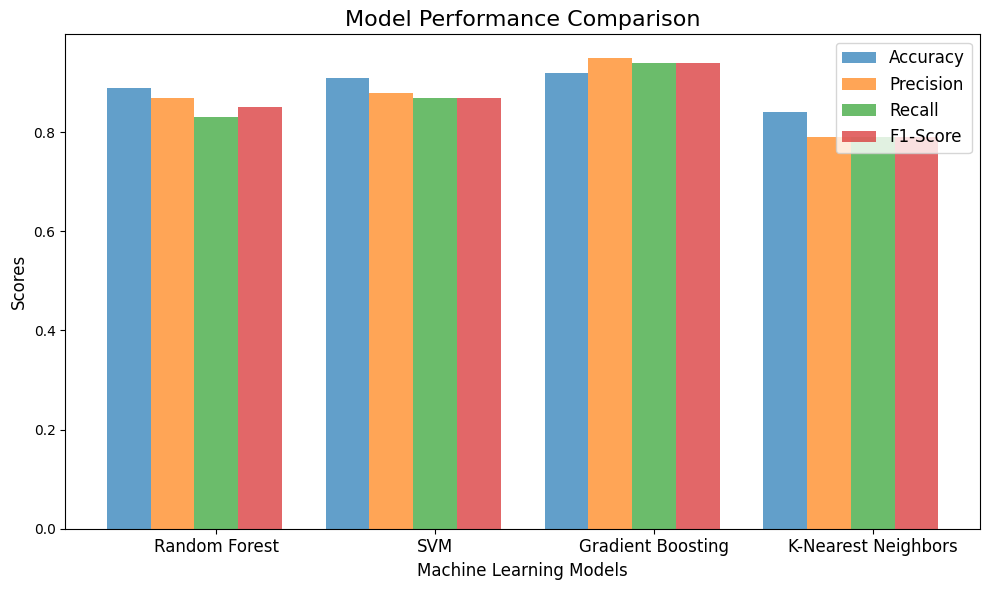

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Random Forest', 'SVM', 'Gradient Boosting', 'K-Nearest Neighbors']
accuracy = [0.89, 0.91, 0.92, 0.84]
precision = [0.87, 0.88, 0.95, 0.79]
recall = [0.83, 0.87, 0.94, 0.79]
f1_score = [0.85, 0.87, 0.94, 0.79]

bar_width = 0.2

index = np.arange(len(models))

fig, axs = plt.subplots(figsize=(10, 6))
bar1 = axs.bar(index - bar_width, accuracy, bar_width, label='Accuracy', alpha=0.7)
bar2 = axs.bar(index, precision, bar_width, label='Precision', alpha=0.7)
bar3 = axs.bar(index + bar_width, recall, bar_width, label='Recall', alpha=0.7)
bar4 = axs.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', alpha=0.7)

axs.set_xlabel('Machine Learning Models', fontsize=12)
axs.set_ylabel('Scores', fontsize=12)
axs.set_title('Model Performance Comparison', fontsize=16)
axs.set_xticks(index + bar_width)
axs.set_xticklabels(models, fontsize=12)
axs.legend(fontsize=12)

plt.tight_layout()
plt.show()


### Which feature was most important?

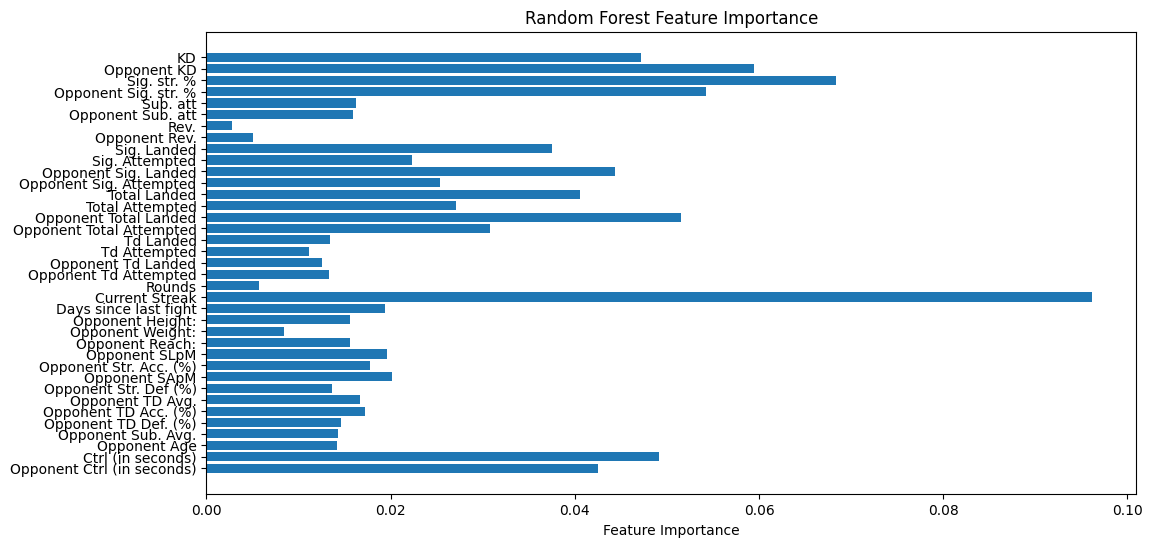

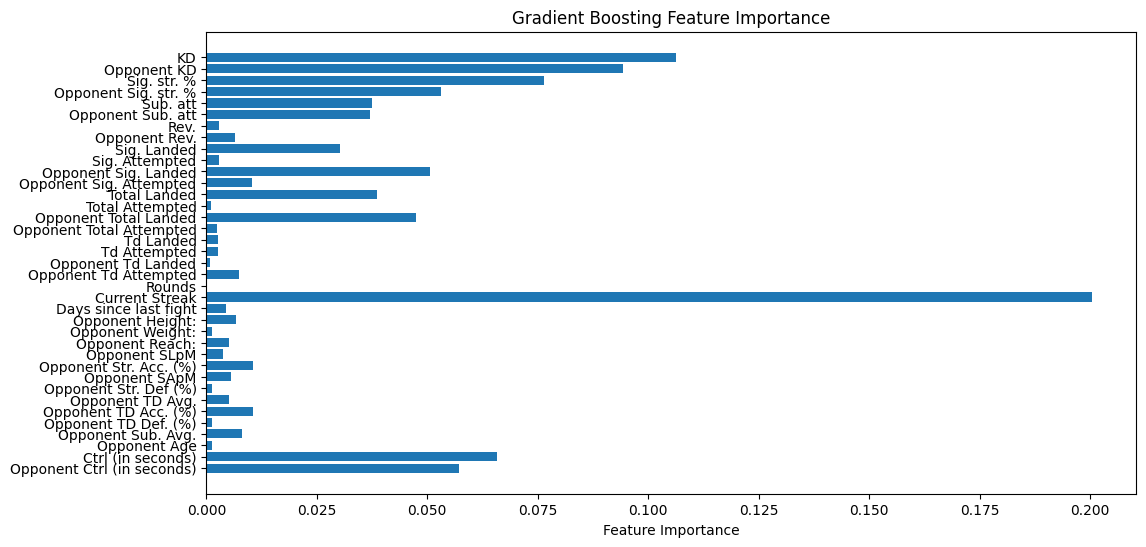

In [ ]:
import matplotlib.pyplot as plt

feature_names = X.columns
# Random Forest Feature Importance
rf_feature_importance = rf_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.barh(feature_names, rf_feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Gradient Boosting Feature Importance
gb_feature_importance = gb_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.barh(feature_names, gb_feature_importance)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()
plt.show()


# Conclusion

In summary, I conducted an analysis utilizing machine learning models to predict fight outcomes within the UFC. The models exhibited commendable performance, achieving an overall accuracy rate of approximately 90%. Among these models, Gradient Boosting emerged as the top performer, demonstrating slightly superior predictive capabilities.

One notable discovery was the significance of a fighter's momentum, often referred to as their winning streak. This feature emerged as a pivotal factor in forecasting fight results, underscoring the importance of a fighter's recent performance history.

**Limitations:**

I exclusively worked with the top 10 fighters in each weight class, with certain fighters excluded due to challenges in collecting their profile data. Furthermore, the inherent unpredictability of sports, influenced by factors such as crowd dynamics, pre-fight interactions, suboptimal strategies, weight-cutting issues, and training camp quality, can significantly sway fight outcomes.

Combat sports, including UFC, impose substantial physical demands on athletes. Consequently, most fighters participate in only 1 to 3 bouts per year, resulting in relatively scarce data.

Outliers, including fight outcomes influenced by injuries or fortunate singular strikes, further contribute to the complexity of predicting results.

**Future Directions:**

To enhance this analysis, several avenues can be explored:

- Expanding the scope of the analysis to encompass the entire UFC roster, providing a more comprehensive dataset for analysis.
- Delving into more granular statistics, such as strikes landed on specific body parts, to fine-tune prediction accuracy.
- Developing an automated script to fetch real-time data from the official UFC website, ensuring the dataset remains up-to-date.
- Investigating whether predictive performance varies across different weight classes, potentially shedding light on weight-related factors affecting fight outcomes.
- Notably, other fight outcomes like "No Contest" or "Disqualification" were not included in this analysis.

In essence, while these models offer valuable insights for predicting UFC fight results, they should be considered as part of a broader strategy for sports betting. The dynamic and unpredictable nature of combat sports necessitates a multifaceted approach to making informed predictions.